In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from sklearn.model_selection import train_test_split

import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# own utils # TODO resolve namespace pollution by restricitn g importis in init
from utils.configuration import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.loss_continous import *
from utils.tram_data_helpers import *
from scipy.special import logit

Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "working_version"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Loaded existing configuration from /home/bule/TramDag/dev_experiment_logs/working_version/configuration.json


# 2.  Data

- same experiment as in https://arxiv.org/pdf/2503.16206 6.1 Conitnous Case
- provide data in the form of a pandas dataframe, if there are iamges add the paths to each image to the df

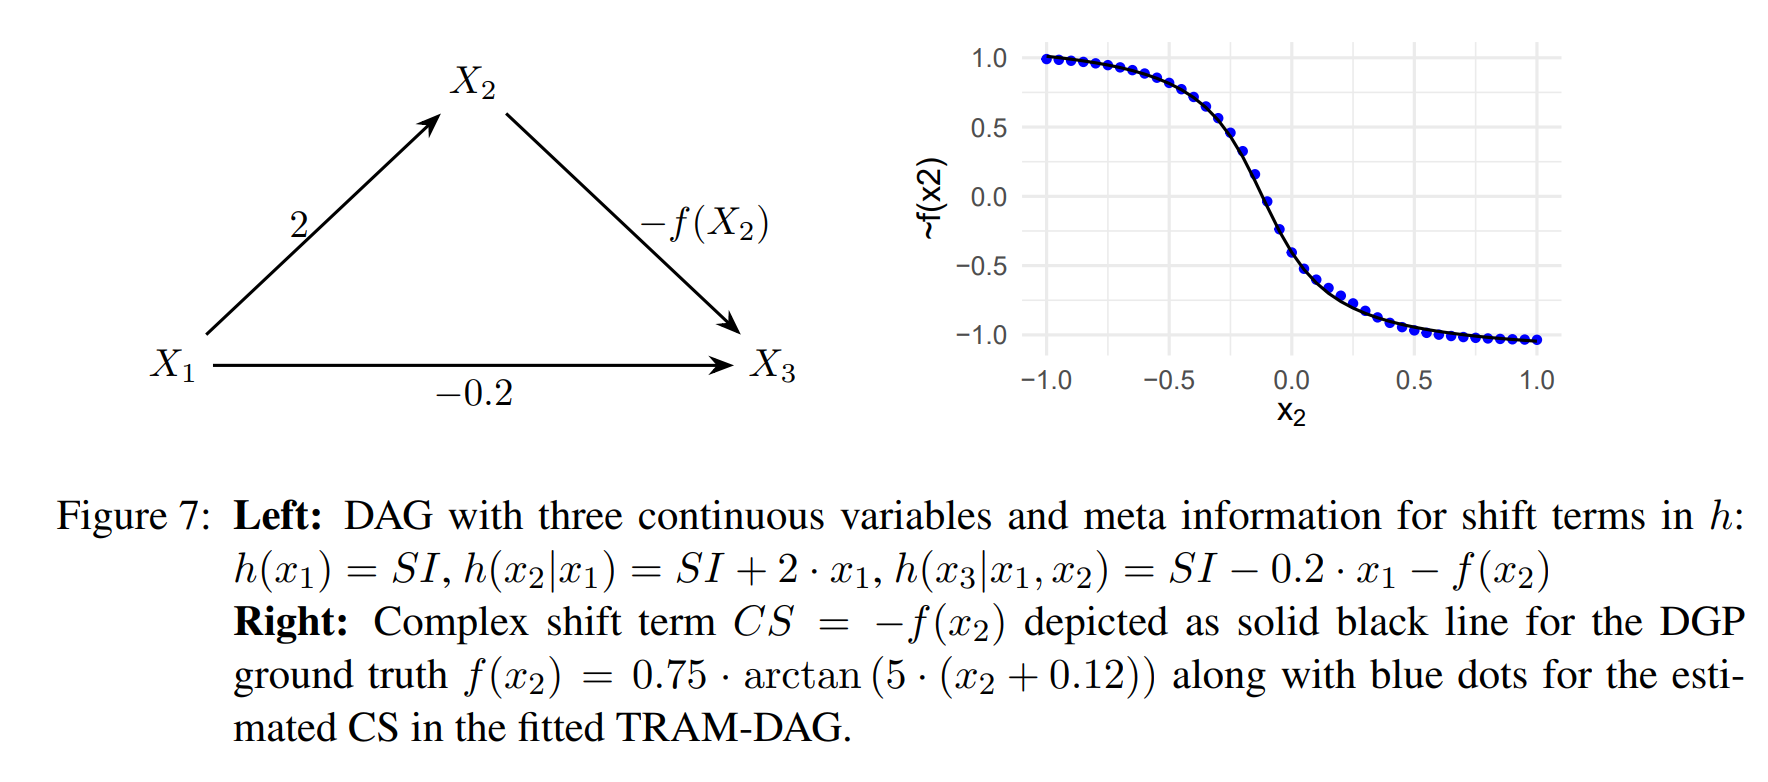

1. Linear-shift DGP and linear-shift model 

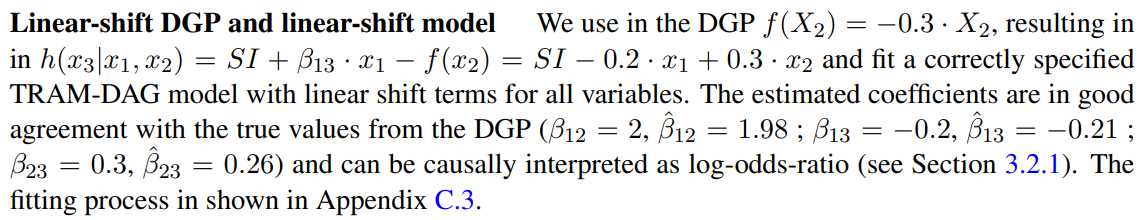

In [3]:
configuration_dict

{'date_of_creation': '2025-09-22 07:59:26',
 'experiment_name': 'working_version',
 'PATHS': {'DATA_PATH': '/home/bule/TramDag/dev_experiment_logs/working_version',
  'LOG_DIR': '/home/bule/TramDag/dev_experiment_logs',
  'EXPERIMENT_DIR': '/home/bule/TramDag/dev_experiment_logs/working_version'},
 'data_type': {'x1': 'continous', 'x2': 'continous', 'x3': 'continous'},
 'adj_matrix': [['0', 'ls', 'ls'], ['0', '0', 'ls'], ['0', '0', '0']],
 'model_names': [['0', 'LinearShift', 'LinearShift'],
  ['0', '0', 'LinearShift'],
  ['0', '0', '0']],
 'seed': None,
 'nodes': {'x1': {'Modelnr': 0,
   'data_type': 'continous',
   'node_type': 'source',
   'parents': [],
   'parents_datatype': {},
   'transformation_terms_in_h()': {},
   'min': 0.1206413817452928,
   'max': 0.7927992044799329,
   'batch_size': 512,
   'epochs': 100,
   'learning_rate': 0.01,
   'use_scheduler': False,
   'transformation_term_nn_models_in_h()': {}},
  'x2': {'Modelnr': 1,
   'data_type': 'continous',
   'node_type': 

Loaded data from /home/bule/TramDag/dev_experiment_logs/working_version/working_version.csv
Variable 'x1' is modeled as a continuous variable. for target and predictor.
Variable 'x2' is modeled as a continuous variable. for target and predictor.
Variable 'x3' is modeled as a continuous variable. for target and predictor.
Configuration updated successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      10000 non-null  float64
 1   x2      10000 non-null  float64
 2   x3      10000 non-null  float64
dtypes: float64(3)
memory usage: 234.5 KB


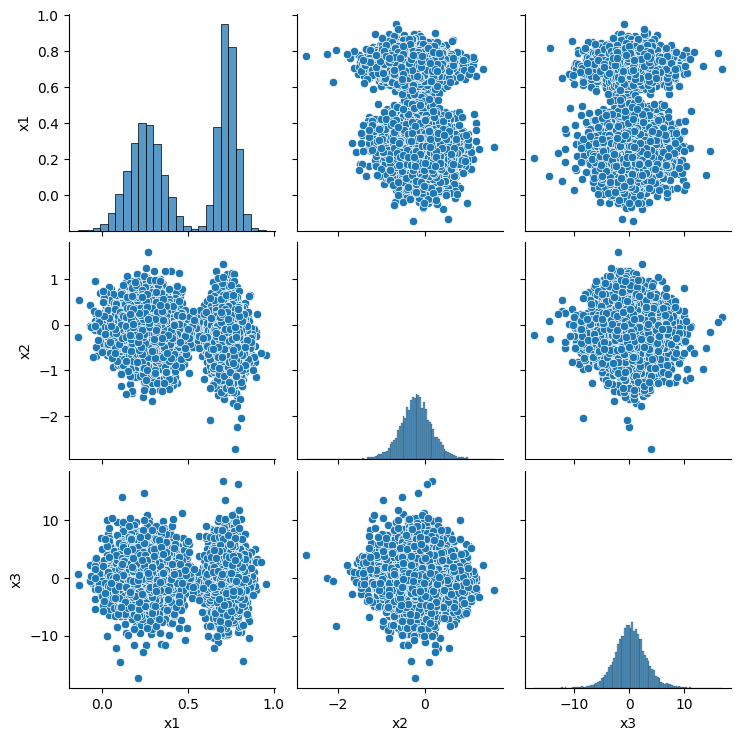

In [4]:
# 1. Linear-shift DGP and linear-shift model 
def f(x):
    return -0.3*x  

def dgp(n_obs, doX=[None, None, None], seed=-1):
    if seed > 0:
        np.random.seed(seed)
        print(f"Setting Seed: {seed}")
    
    # Generate x1 from a 2-component GMM
    
    # h(x1)= SI 
    
    
    if doX[0] is None:
        x1_A = np.random.normal(0.25, 0.1, n_obs)
        x1_B = np.random.normal(0.73, 0.05, n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, x1_A, x1_B)
    else:
        x1 = np.full(n_obs, doX[0])



    # Fz(z)=Fy(y)
    # Fz(h(y|x))=Fy(y)    | z= h(y|x)

    # Generate x2
    
    # h(x2|x1)= Bernsteinpol(x2) + beta2 * x1        | bernsteinpol is just linearized assumed with a constant factor say 0.42
    # h(x2|x1)= 0.42*x2 + beta2 * x1                 | replace h(x2|x1) with z
    # z       = 0.42*x2 + beta2 * x1                 | reformulate to x2
    # x2      = (z-beta2 * x1 )/0.42                 | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x2      = (z-beta2 * x1 )/0.42                 | set beta = 2 (on the edge of the graph)
    # x2      = (z-2 * x1 )/0.42                     |
    
    if doX[1] is None:
        u2 = np.random.uniform(size=n_obs)
        z2 = logit(u2)
        x2 = (z2 - 2 * x1) / 5#5#   0.42  in the trainagle strucutred cont last line is 5 for SI
    else:
        x2 = np.full(n_obs, doX[1])

    # Generate x3
    
    # h(x3|x2,x1)= Bernsteinpol(x3) + beta3 * x1 -f(X2)        | bernsteinpol is just linearized assumed with a constant factor say 0.63
    # h(x3|x2,x1)= 0.63*x3 + beta3 * x1          - f(X2)        | replace h(x2|x1) with z
    # z3          = 0.63*x3 + beta3 * x1          - f(X2)        | reformulate to x2
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | set beta = -0.2 (on the edge of the graph)
    # x3         = (z3+0.2 * x1   +f(X2))/0.63                   | 

    
    if doX[2] is None:
        u3 = np.random.uniform(size=n_obs)
        z3 = logit(u3)
        x3 = (z3 + 0.2 * x1 + f(x2)) / 0.63
    else:
        x3 = np.full(n_obs, doX[2])
        
    #df = pd.DataFrame({'x1': x1, 'x2': x2})#, 'x3': x3})
    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})
    return df

n_obs=10_000


EXP_DATA_PATH=os.path.join(EXPERIMENT_DIR, f"{experiment_name}.csv")

if not os.path.exists(EXP_DATA_PATH):
    df = dgp(n_obs=n_obs, seed=42)
    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")

sns.pairplot(df)

data_type= {'x1':'continous','x2':'continous','x3':'continous'} 

write_data_type_to_configuration(data_type, CONF_DICT_PATH)

df.info()

## 2.1 train test split

In [5]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

train_df.to_csv(os.path.join(EXPERIMENT_DIR, f"{experiment_name}_train.csv"), index=False)
val_df.to_csv(os.path.join(EXPERIMENT_DIR, f"{experiment_name}_val.csv"), index=False)
test_df.to_csv(os.path.join(EXPERIMENT_DIR, f"{experiment_name}_test.csv"), index=False)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 8000, Validation size: 1000, Test size: 1000


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


/home/bule/TramDag/utils/configuration.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


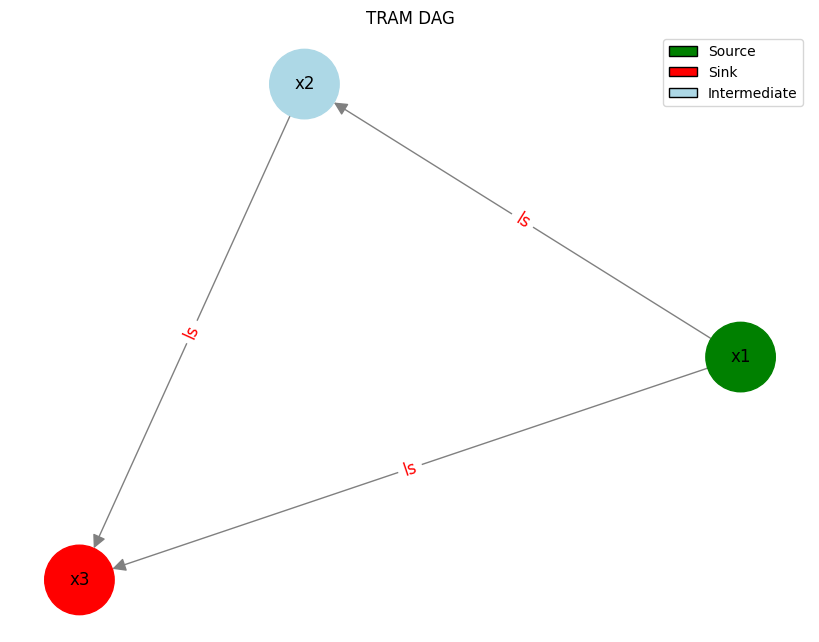

In [6]:

interactive_adj_matrix(CONF_DICT_PATH,seed=10)

# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

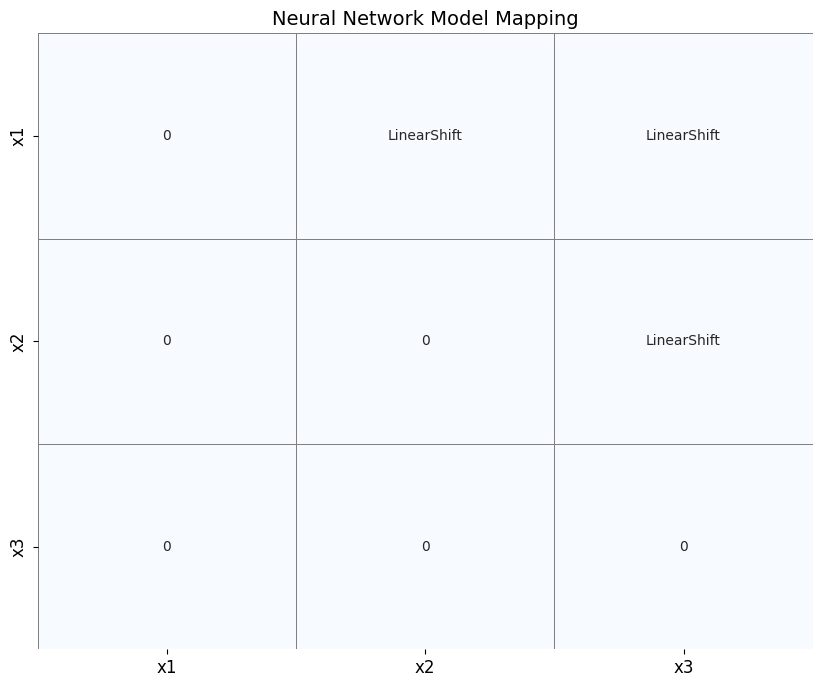

In [7]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [8]:
levels_dict=create_levels_dict(df,data_type)

write_nodes_information_to_configuration(CONF_DICT_PATH, min_vals, max_vals,levels_dict)

{'x1': {'Modelnr': 0, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.1206413817452928, 'max': 0.7927992044799329, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {}}, 'x2': {'Modelnr': 1, 'data_type': 'continous', 'node_type': 'internal', 'parents': ['x1'], 'parents_datatype': {'x1': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls')}, 'min': -0.8113477003510517, 'max': 0.42184081579848054, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift')}}, 'x3': {'Modelnr': 2, 'data_type': 'continous', 'node_type': 'sink', 'parents': ['x1', 'x2'], 'parents_datatype': {'x1': 'continous', 'x2': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls'), 'x2': np.str_('ls')}, 'min': -4.428279471987848, 'max': 4.908985586156537

----------------------------------------------------------------------------------------------------------

In [9]:
# hyperparams:
train_list=['x1','x2','x3']#<-  set the nodes which have to be trained , useful if further training is required else lsit all vars
configuration_dict = load_configuration_dict(CONF_DICT_PATH)
# if you change the hyperparams -> write them to the config file!

In [10]:
# For each NODE 
node_list = configuration_dict['nodes'] 

for node in node_list:
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')

    ########################## 0. Get hyperparameters ###############################
    # batch_size, epochs, learning_rate, use_scheduler = get_hyperparameters_for_node(node,node_list)
    
    ############ Edited hyperparameters ##########
    batch_size = 512
    epochs = 800
    learning_rate = 0.01
    use_scheduler = False
    ###########################################
    
    print(f"Using hyperparameters: batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}, use_scheduler={use_scheduler}\n")
    
    ########################## 1. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (node_list[node]['node_type'] == 'source') and (node_list[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 2. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    

    ########################## 3. Check if training is complete ###############################
    if not check_if_training_complete(node, NODE_DIR, epochs):
        continue
    
    ########################## 4. Create Model ##############################
    tram_model= get_fully_specified_tram_model(node, configuration_dict, debug=True, set_initial_weights=True)
    
    ########################## 5. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, node_list, train_df, val_df, batch_size=batch_size,return_intercept_shift=True, debug=False)

    ########################## 6. Optimizer & Scheduler ######################.
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 7. Training Loop ##############################
    
    train_val_loop(
                node,
                node_list,
                NODE_DIR,
                tram_model,
                train_loader,
                val_loader,
                epochs,
                optimizer,
                use_scheduler,
                scheduler,
                save_linear_shifts=True,
                verbose=1,
                device=device,
                debug=False) # TODO startvalues for bernsteinpols




----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
Using hyperparameters: batch_size=512, epochs=800, learning_rate=0.01, use_scheduler=False

Node x1 already trained for 800 epochs. Skipping.

----*----------*-------------*--------------- Node: x2 ------------*-----------------*-------------------*--
Using hyperparameters: batch_size=512, epochs=800, learning_rate=0.01, use_scheduler=False

Node x2 already trained for 800 epochs. Skipping.

----*----------*-------------*--------------- Node: x3 ------------*-----------------*-------------------*--
Using hyperparameters: batch_size=512, epochs=800, learning_rate=0.01, use_scheduler=False

Node x3 already trained for 800 epochs. Skipping.


# 6 Inspect Training

## 6.1 Loss vs epochs

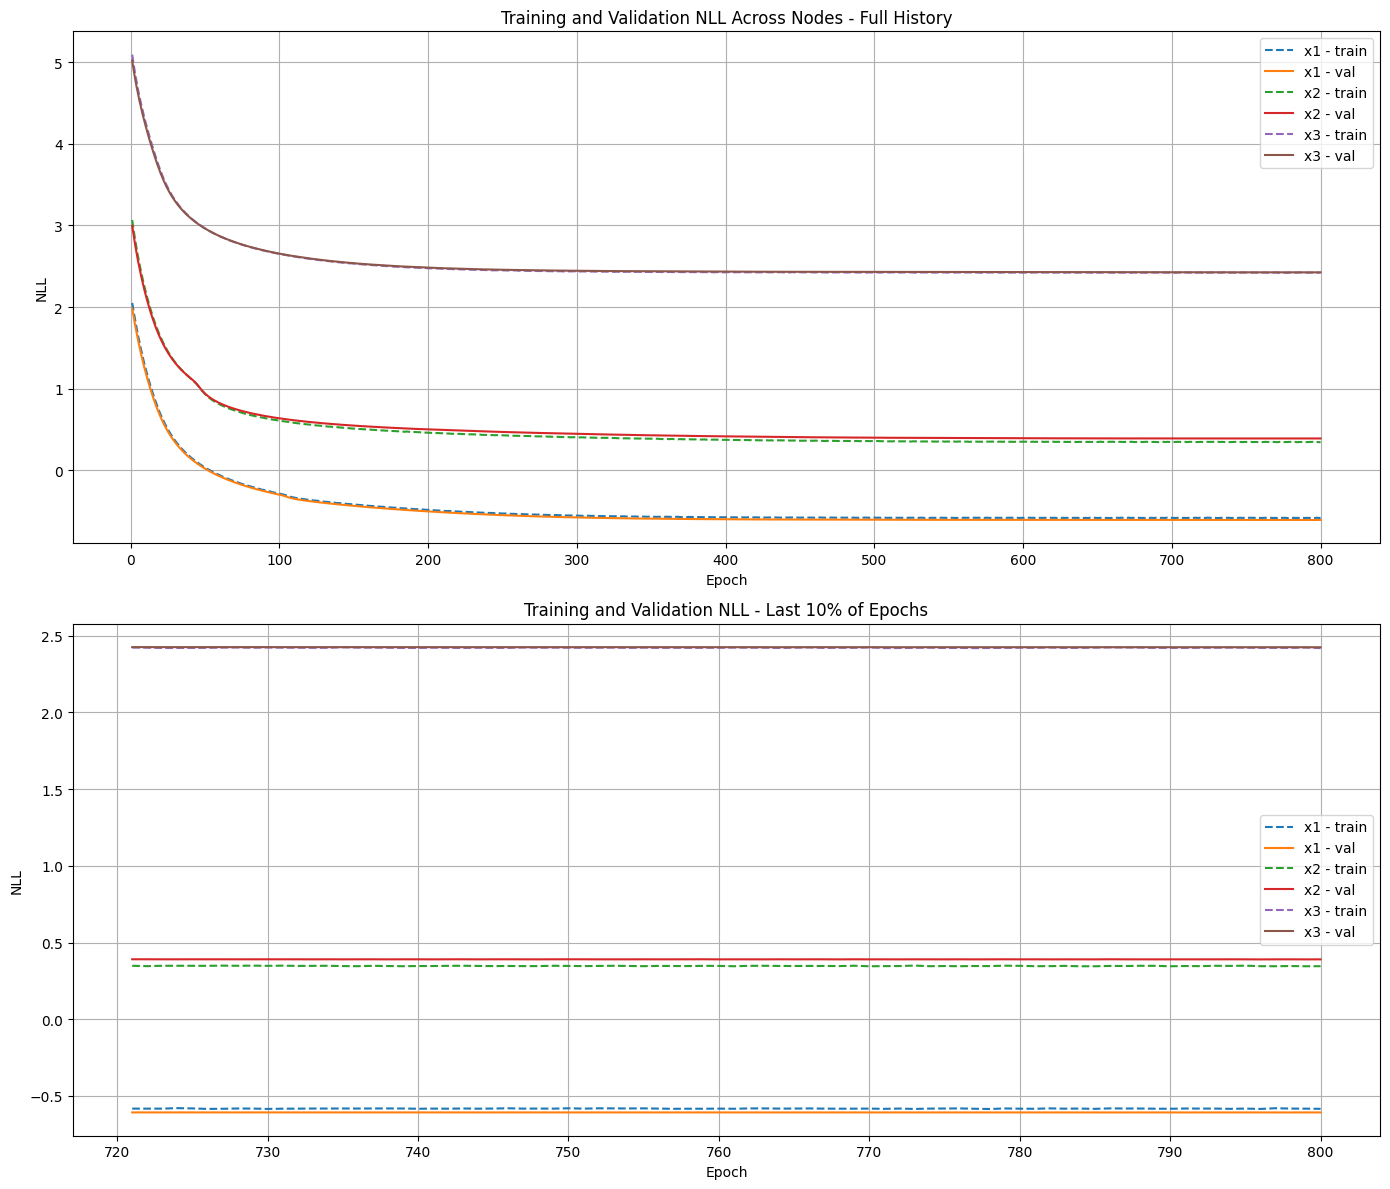

In [11]:
show_training_history(node_list,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


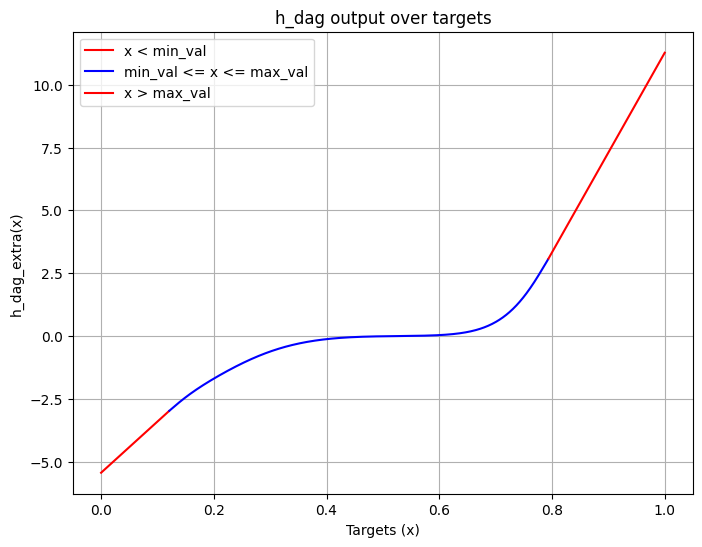

In [12]:
show_hdag_for_source_nodes(configuration_dict,EXPERIMENT_DIR,device=device,xmin_plot=0,xmax_plot=1) # TODO for other nodes funciton

----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


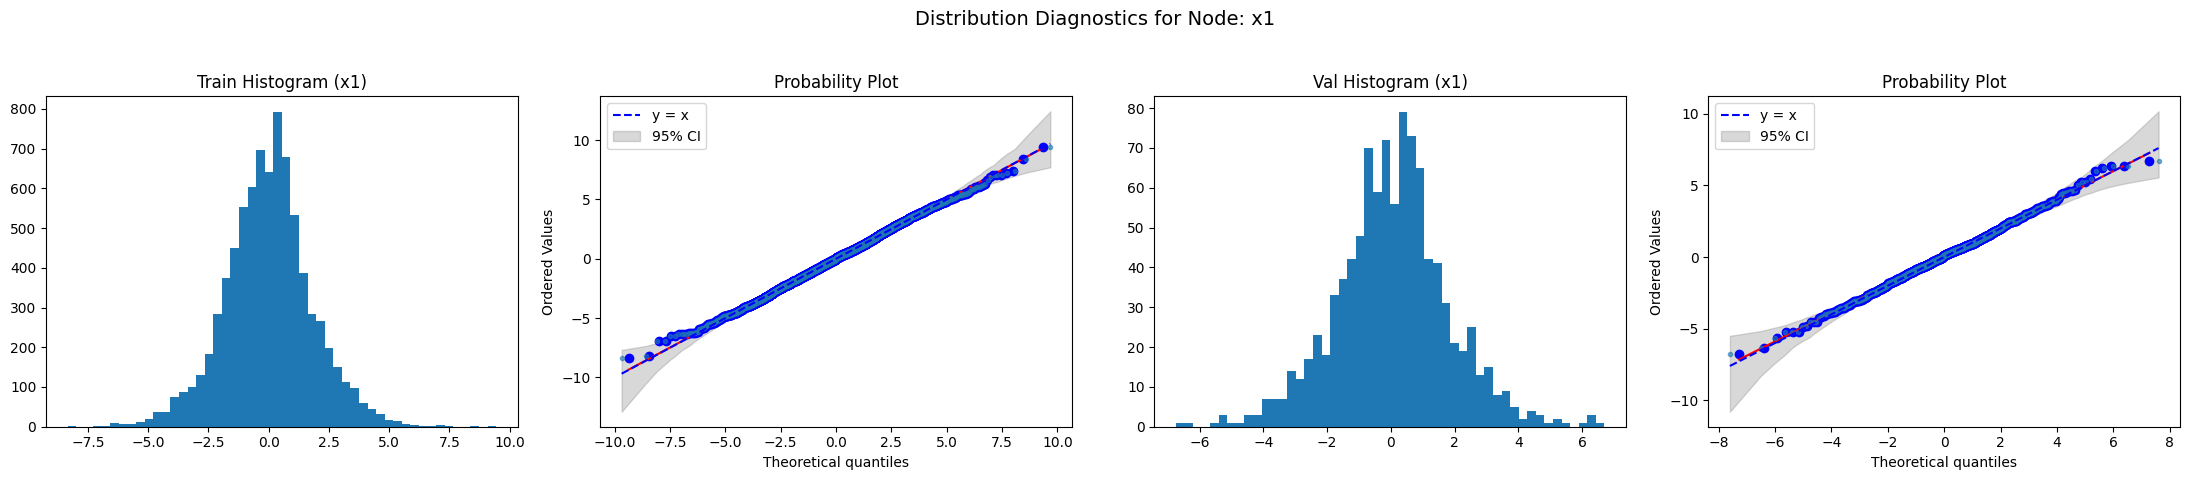

----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


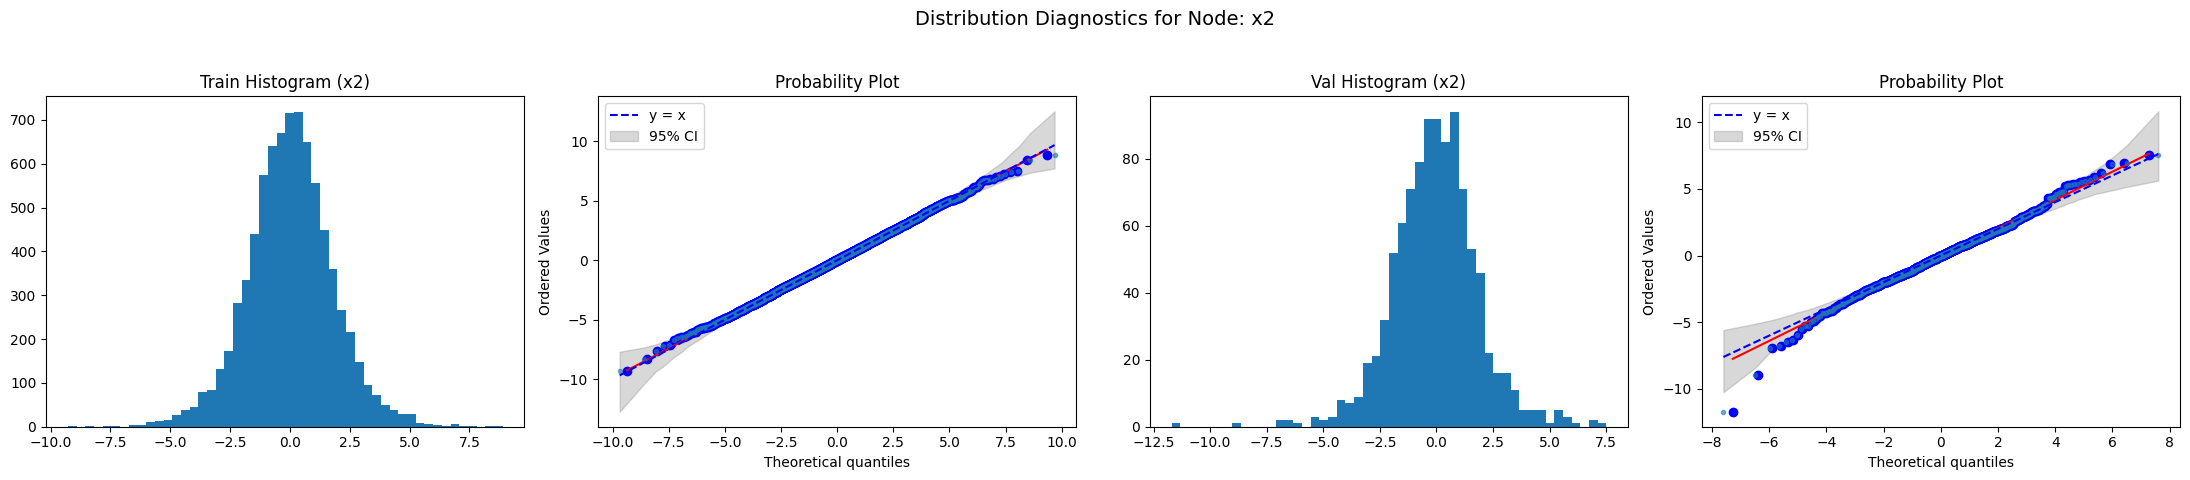

----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--


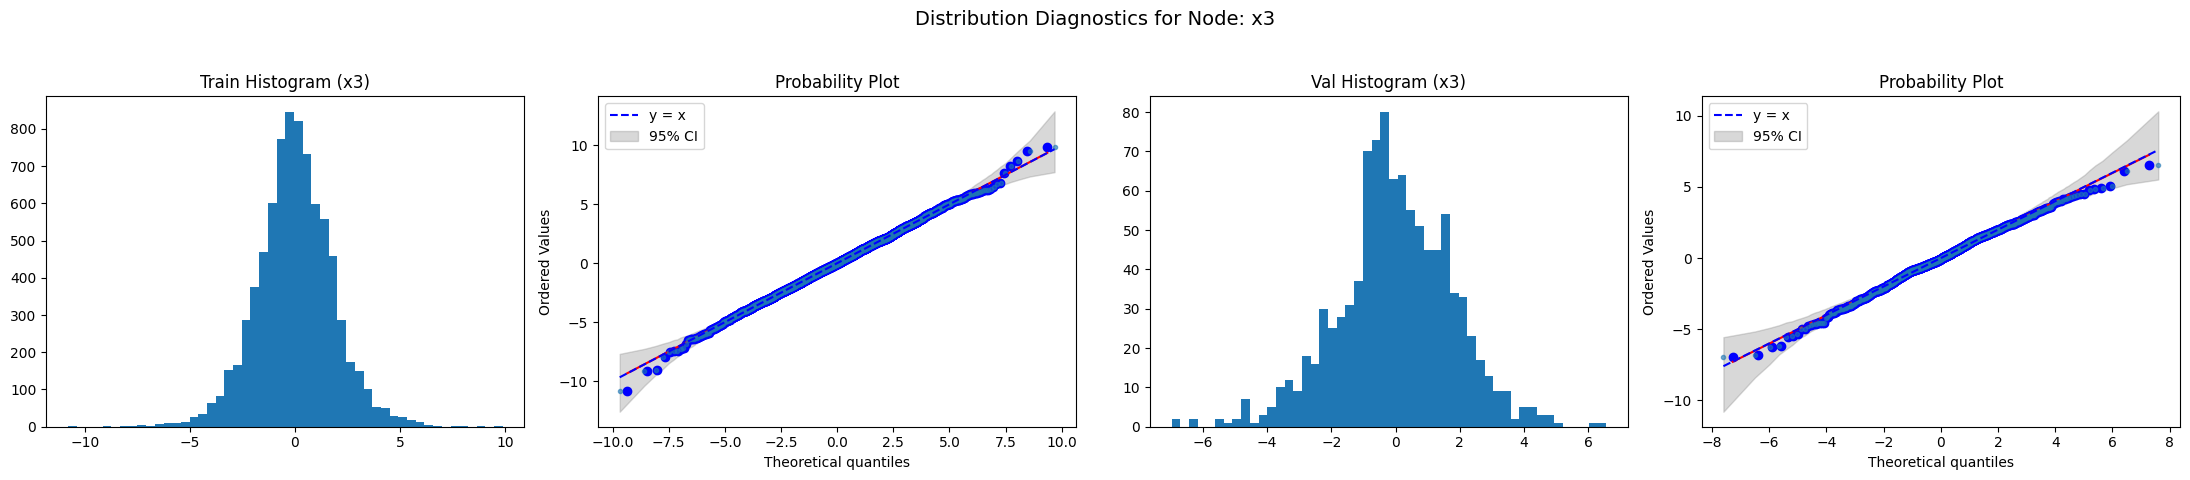

(array([[-0.28908715,  1.4775463 , -3.7380104 ],
        [-0.47238111,  3.3626297 ,  1.8384935 ],
        [ 0.5460962 , -0.6147746 , -2.5475187 ],
        ...,
        [-3.8240018 , -8.325639  , -1.740727  ],
        [-1.0433874 ,  0.7411659 ,  1.8637918 ],
        [-0.53082854,  4.643814  ,  3.0910885 ]], dtype=float32),
 array([[-0.45630074,  2.2341206 ,  0.7366545 ],
        [-0.42277798, -0.9248296 ,  3.5710793 ],
        [-1.0548844 , -0.70769846,  1.5968308 ],
        ...,
        [-0.3496004 ,  0.43284824,  1.0056379 ],
        [-0.24337868,  6.845714  , -0.79959166],
        [-1.2947805 , -0.46367115,  1.3612567 ]], dtype=float32))

In [13]:
inspect_trafo_standart_logistic(configuration_dict,EXPERIMENT_DIR,train_df,val_df,device,verbose=False)

### a function which returns all the latents for input data

provide_latents_for_input_data()




### Coefficient estimates


----*----------*-------------*--------check LS of x1 ------------*-----------------*-------------------*--
Node type :source

----*----------*-------------*--------check LS of x2 ------------*-----------------*-------------------*--


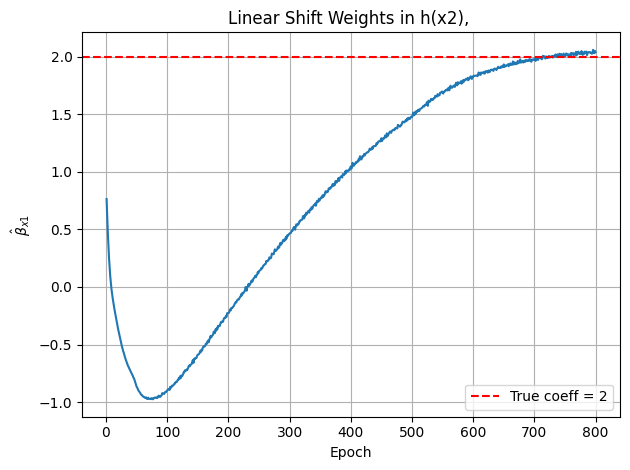


----*----------*-------------*--------check LS of x3 ------------*-----------------*-------------------*--


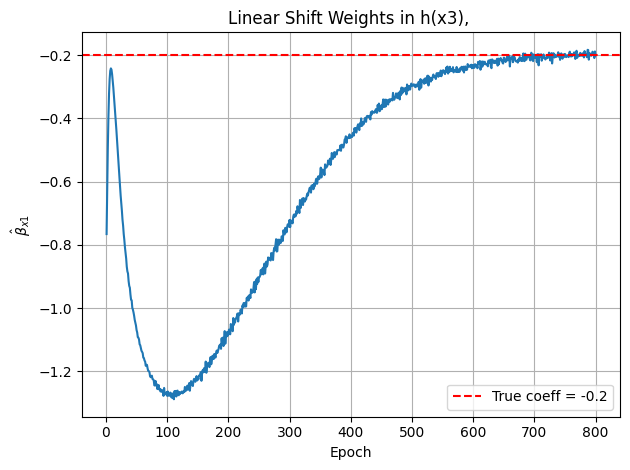

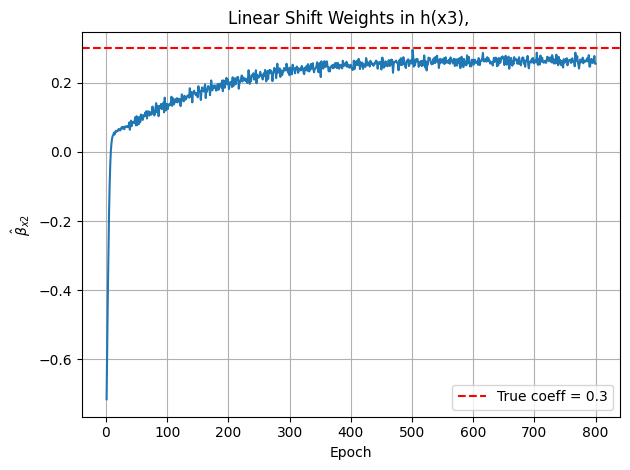

In [14]:
# x1-> x2, x1-> x3, x2-> x3
true_coeffs = {'x2': [2],'x3': [-0.2, 0.3]}

for node in node_list:
    print(f'\n----*----------*-------------*--------check LS of {node} ------------*-----------------*-------------------*--')
    
    if node_list[node]['node_type'] == 'source':
        print(f"Node type :source")
        continue
    
    # Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    # Load saved shifts
    shift_path = os.path.join(NODE_DIR, "linear_shifts_all_epochs.json")
    with open(shift_path, 'r') as f:
        all_shift_weights = json.load(f)

    # Sort epochs numerically
    epochs = sorted(all_shift_weights.keys(), key=lambda x: int(x.split('_')[1]))

    # Number of shifts (incoming edges) for this node
    example_epoch = all_shift_weights[epochs[0]]
    num_shifts = len(example_epoch)

    # Plot per shift (incoming edge)
    for shifts_idx in range(num_shifts):
        shift_name = f"shift_{shifts_idx}"
        weights_over_time = []

        for epoch in epochs:
            weight_matrix = np.array(all_shift_weights[epoch][shift_name])  # shape: [out_features, in_features]
            avg_weight = weight_matrix.mean()
            weights_over_time.append(avg_weight)

        plt.figure()
        plt.plot(range(1, len(epochs) + 1), weights_over_time)

        # If this node has a true coefficient for this shift, draw a horizontal red line
        if node in true_coeffs:
            true_val = true_coeffs[node][shifts_idx]
            plt.axhline(y=true_val, color='r', linestyle='--', label=f"True coeff = {true_val}")
            plt.legend()

        plt.title(f"Linear Shift Weights in h({node}), ")
        plt.xlabel("Epoch")
        plt.ylabel(fr'$\hat{{\beta}}_{{{node_list[node]["parents"][shifts_idx]}}}$')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

- best model , parameters

In [15]:
verbose=False
batch_size = 4112
for node in node_list:
    print(f'\n----*----------*-------------*--------check CS of {node} ------------*-----------------*-------------------*--')
    
    if (node_list[node]['node_type'] == 'source'):
        print(f"Node type : other , is not supported yet")
        continue
    #### 0. Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    
    ##### 1. Load model 
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, configuration_dict, debug=verbose)
    tram_model = tram_model.to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()
    
        
    for i in range(len(tram_model.nn_shift)):
        print(tram_model.nn_shift[i].fc.weight.data)
    


----*----------*-------------*--------check CS of x1 ------------*-----------------*-------------------*--
Node type : other , is not supported yet

----*----------*-------------*--------check CS of x2 ------------*-----------------*-------------------*--
tensor([[2.0583]], device='cuda:0')

----*----------*-------------*--------check CS of x3 ------------*-----------------*-------------------*--
tensor([[-0.1881]], device='cuda:0')
tensor([[0.2554]], device='cuda:0')


# 7. Sample from Graph

In [16]:

def provide_latents_for_input_data(
    node,
    configuration_dict,
    EXPERIMENT_DIR,
    data_loader,
    base_df,
    verbose=False
):
    """
    Compute latent representations for each observation in base_df
    and return a DataFrame with columns [node, "_U"] aligned with base_df.
    """
    
    target_nodes = configuration_dict["nodes"]
    if is_outcome_modelled_ordinal(node, target_nodes):
        raise ValueError("Not yet defined for ordinal target variables")

    #### 0. Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f"{node}")

    ##### 1. Load model 
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(
        node, configuration_dict, debug=verbose, set_initial_weights=False
    )
    tram_model = tram_model.to(device)
    tram_model.load_state_dict(torch.load(model_path, map_location=device))
    tram_model.eval()

    #### 2. Forward Pass
    min_vals = torch.tensor(target_nodes[node]["min"], dtype=torch.float32, device=device)
    max_vals = torch.tensor(target_nodes[node]["max"], dtype=torch.float32, device=device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    latents_list = []
    with torch.no_grad():
        for (int_input, shift_list), y in data_loader:
            # Move everything to device
            int_input = int_input.to(device)
            shift_list = [s.to(device) for s in shift_list]
            y = y.to(device)  # targets to device
            y_pred = tram_model(int_input=int_input, shift_input=shift_list)

            latents, _ = contram_nll(y_pred, y, min_max=min_max, return_h=True)
            latents_list.extend(latents.cpu().numpy())

    # Turn into DataFrame aligned with base_df
    latents_df = pd.DataFrame({
        node: base_df[node].values,
        f"{node}_U": latents_list
    }, index=base_df.index)

    return latents_df


def create_latent_df_for_full_dag(configuration_dict, EXPERIMENT_DIR, train_df, verbose=False):

    all_latents_dfs = []

    for node in configuration_dict["nodes"]:
        # Skip ordinal outcomes if not supported
        if is_outcome_modelled_ordinal(node, configuration_dict["nodes"]):
            print(f"[INFO] Skipping node '{node}' (ordinal targets not yet supported).")
            continue

        if verbose:
            print(f"[INFO] Processing node '{node}'")

        # Build dataset and dataloader for this node
        node_dataset = GenericDataset(
            train_df,
            target_col=node,
            target_nodes=configuration_dict["nodes"]
        )
        node_loader = DataLoader(
            node_dataset,
            batch_size=4096,   # you can tune this
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )

        # Compute latents
        node_latents_df = provide_latents_for_input_data(
            node=node,
            configuration_dict=configuration_dict,
            EXPERIMENT_DIR=EXPERIMENT_DIR,
            data_loader=node_loader,
            base_df=train_df,
            verbose=verbose
        )

        all_latents_dfs.append(node_latents_df)

    # Concatenate all node-specific latent dataframes
    all_latents_df = pd.concat(all_latents_dfs, axis=1)

    # Remove duplicate index columns (if multiple nodes included their own target col)
    all_latents_df = all_latents_df.loc[:, ~all_latents_df.columns.duplicated()]

    print("[INFO] Final latent DataFrame shape:", all_latents_df.shape)
    return all_latents_df

all_latents_df = create_latent_df_for_full_dag(configuration_dict, EXPERIMENT_DIR, train_df, verbose=True)
all_latents_df.head()

[INFO] Processing node 'x1'
[INFO] Processing node 'x2'
[INFO] Processing node 'x3'
[INFO] Final latent DataFrame shape: (8000, 6)


,x1,x1_U,x2,x2_U,x3,x3_U
9254,0.850619,5.337778,-0.743961,-1.903564,1.361409,0.518576
1561,0.672853,0.287439,0.034002,1.539557,1.854532,1.085492
1670,0.226107,-1.368077,0.340756,2.079216,-3.312690,-2.041911
6087,0.095220,-3.504259,-0.454555,-2.074745,-0.759672,-0.565022
6669,0.720547,0.872313,0.107613,1.996884,1.989365,1.186603


In [ ]:
def sample_full_dag(configuration_dict,
                    EXPERIMENT_DIR,
                    device,
                    do_interventions={},
                    predefined_latent_samples_df: pd.DataFrame = None,
                    number_of_samples: int = 10_000,
                    batch_size: int = 32,
                    delete_all_previously_sampled: bool = True,
                    verbose: bool = True,
                    debug: bool = False):
    """
    Sample values for all nodes in a DAG given trained TRAM models, respecting
    parental ordering. Supports both generative sampling (new U's) and
    reconstruction sampling (predefined U's), as well as node-level interventions.

    Parameters
    ----------
    configuration_dict : dict
        Full experiment configuration. Must contain a "nodes" entry where each node
        has metadata including:
            - 'node_type': str, either 'source' or other
            - 'parents': list of parent node names
            - 'min': float, minimum allowed value for the node
            - 'max': float, maximum allowed value for the node
            - 'data_type': str, e.g. "continuous" or "ordinal"
    EXPERIMENT_DIR : str
        Base directory where per-node models and sampling results are stored.
    device : torch.device
        Device for model evaluation (e.g., 'cuda' or 'cpu').
    do_interventions : dict, optional
        Mapping of node names to fixed values. For intervened nodes, the model is
        bypassed and all samples are set to the specified value. Example:
        {'x1': 1.0}.
    predefined_latent_samples_df : pd.DataFrame, optional
        DataFrame of predefined latent variables (U's) for reconstruction. Must
        contain one column per node in the form "{node}_U". If provided, the number
        of samples is set to the number of rows in this DataFrame.
    number_of_samples : int, default=10_000
        Number of samples to draw per node when no predefined latent samples are given.
    batch_size : int, default=32
        Batch size for DataLoader evaluation during sampling.
    delete_all_previously_sampled : bool, default=True
        If True, deletes all existing sampled.pt/latents.pt files before starting.
    verbose : bool, default=True
        If True, print progress information.
    debug : bool, default=False
        If True, print detailed debug information for troubleshooting.

    Returns
    -------
    sampled_by_node : dict
        Mapping from node name to a tensor of sampled values (on CPU).
    latents_by_node : dict
        Mapping from node name to the latent variables (U's) used to generate
        those samples (on CPU).

    Notes
    -----
    - The function respects DAG ordering by ensuring parents are sampled before
      their children.
    - In generative mode (no predefined_latent_samples_df), latent U's are sampled
      from a standard logistic distribution and parents are taken from sampled.pt.
    - In reconstruction mode (with predefined_latent_samples_df), latent U's are
      read from the DataFrame, but parent values are still loaded from sampled.pt
      unless explicitly overridden upstream.
    - Models are loaded from "best_model.pt" in each node's directory and applied
      in eval mode with no gradient tracking.
    - Continuous outcomes are sampled via vectorized root finding
      (Chandrupatla's algorithm), while ordinal outcomes use categorical sampling.
    """
    
    if predefined_latent_samples_df is not None:
        print(f'[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: {len(predefined_latent_samples_df)}')
        number_of_samples = len(predefined_latent_samples_df)
        
    
    target_nodes_dict=configuration_dict["nodes"]

    # Collect results for direct use in notebooks
    sampled_by_node = {}
    latents_by_node = {}


    if delete_all_previously_sampled:
        if verbose or debug:
            print("[INFO] Deleting all previously sampled data.")
        delete_all_samplings(target_nodes_dict, EXPERIMENT_DIR)
    
    max_iterations,iteration=200,0
    processed_nodes=[] # log the processed nodes in this list
    
    # repeat process until all nodes are sampled
    while set(processed_nodes) != set(target_nodes_dict.keys()): 
        iteration += 1
        if iteration > max_iterations:
            raise RuntimeError("Too many iterations in sampling loop, possible infinite loop.")
        
        for node in target_nodes_dict: # for each node in the target_nodes_dict
            if node in processed_nodes:
                if verbose :
                    print(f"[INFO] Node '{node}' already processed.")
                continue
                        
            print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--') 
            
            ## 1. Paths 
            NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
            SAMPLING_DIR = os.path.join(NODE_DIR, 'sampling')
            os.makedirs(SAMPLING_DIR, exist_ok=True)
            SAMPLED_PATH = os.path.join(SAMPLING_DIR, "sampled.pt")
            LATENTS_PATH = os.path.join(SAMPLING_DIR, "latents.pt")
            
            ## 2. Check if sampled and latents already exist 
            try:
                if check_sampled_and_latents(NODE_DIR, debug=debug):
                    processed_nodes.append(node)
                    continue
            except FileNotFoundError:
                pass
            
            ## 3. logic to make sure parents are always sampled first
            skipping_node = False
            if target_nodes_dict[node]['node_type'] != 'source':
                for parent in target_nodes_dict[node]['parents']:
                    parent_dir = os.path.join(EXPERIMENT_DIR, parent)
                    try:
                        check_sampled_and_latents(parent_dir, debug=debug)
                    except FileNotFoundError:
                        skipping_node = True
                        if verbose or debug:
                            print(f"[INFO] Skipping {node} as parent '{parent}' is not sampled yet.")
                        break

            if skipping_node:
                continue
            
            ## INTERVENTION, if node is to be intervened on , data is just saved
            if do_interventions and node in do_interventions.keys():
                    # For interventions make all the values the same for 
                    intervention_value = do_interventions[node]
                    if verbose or debug:
                        print(f"[INFO] Applying intervention for node '{node}' with value {intervention_value}")
                    intervention_vals = torch.full((number_of_samples,), intervention_value)
                    torch.save(intervention_vals, SAMPLED_PATH)
                    
                    ### dummy latents jsut for the check , not needed
                    dummy_latents = torch.full((number_of_samples,), float('nan'))  
                    torch.save(dummy_latents, LATENTS_PATH)
                    
                    # Store for immediate use
                    sampled_by_node[node] = intervention_vals
                    latents_by_node[node] = dummy_latents
                    
                    processed_nodes.append(node)
                    print(f'Interventional data for node {node} is saved')
                    continue  
                
            ##### NO INTERVENTION, based on the sampled data from the parents the latents for each node the observational distribution is generated    
            else:
                # if latents are predefined use them
                if predefined_latent_samples_df is not None:
                    predefinded_sample_name = node + "_U"

                    if predefinded_sample_name not in predefined_latent_samples_df.columns:
                        raise ValueError(
                            f"Predefined latent samples for node '{node}' not found in dataframe columns. "
                            f"Must be named '{predefinded_sample_name}'.")
                        
                    predefinded_sample = predefined_latent_samples_df[predefinded_sample_name].values
                    print(f'[INFO] Using predefined latents samples for node {node} from dataframe column: {predefinded_sample_name}')
                    
                    latent_sample = torch.tensor(predefinded_sample, dtype=torch.float32).to(device)
                    
                    ### sampling new latents
                else:
                    print(f'[INFO] Sampling new latents for node {node} from standard logistic distribution')
                    latent_sample = torch.tensor(logistic.rvs(size=number_of_samples), dtype=torch.float32).to(device)
                    
                
                ### load modelweights
                MODEL_PATH = os.path.join(NODE_DIR, "best_model.pt")
                tram_model = get_fully_specified_tram_model(node, configuration_dict, debug=True).to(device)
                tram_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
                
                # isntead of sample loader use Generic Dataset but the df is just to sampled data from befor -> create df for each node
                sampled_df=create_df_from_sampled(node, target_nodes_dict, number_of_samples, EXPERIMENT_DIR)
                
                sample_dataset = GenericDataset(sampled_df,target_col=node,
                                                    target_nodes=target_nodes_dict,
                                                    return_intercept_shift=True,
                                                    return_y=False,
                                                    debug=debug)
                
                sample_loader = DataLoader(sample_dataset, batch_size=batch_size, shuffle=False,num_workers=4, pin_memory=True)
                
                ###*************************************************** Continous Modelled Outcome ************************************************
                
                if is_outcome_modelled_continous(node,target_nodes_dict):
                    sampled=sample_continous_modelled_target(node,target_nodes_dict,sample_loader,tram_model,latent_sample,device=device, debug=debug)
                    
                ###*************************************************** Ordinal Modelled Outcome ************************************************
                
                elif is_outcome_modelled_ordinal(node,target_nodes_dict):
                    sampled=sample_ordinal_modelled_target(sample_loader,tram_model,device=device, debug=debug)
                
                else:
                    raise ValueError(f"Unsupported data_type '{target_nodes_dict[node]['data_type']}' for node '{node}' in sampling.")
                    
                ###*************************************************** Saving the latenst and sampled  ************************************************
                if torch.isnan(sampled).any():
                    print(f"[WARNING] NaNs detected in sampled output for node '{node}'")
                    
                torch.save(sampled, SAMPLED_PATH)
                torch.save(latent_sample, LATENTS_PATH)
                
                # Store CPU copies for immediate use
                sampled_by_node[node] = sampled.detach().cpu()
                latents_by_node[node] = latent_sample.detach().cpu()
                
                if verbose:
                    print(f"[INFO] Completed sampling for node '{node}'")
                
                processed_nodes.append(node)          
        
    if verbose:
        print("[INFO] DAG sampling completed successfully for all nodes.")

    return sampled_by_node, latents_by_node

In [21]:
sampled_by_node, latents_by_node=sample_full_dag(configuration_dict,
                EXPERIMENT_DIR,
                device,
                do_interventions={},
                predefined_latent_samples_df=all_latents_df,
                number_of_samples= 10_000,
                batch_size = 32,
                delete_all_previously_sampled=True,
                verbose=True,
                debug=False)

[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 8000
[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/working_version/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/working_version/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/working_version/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:29<00:00, 337.86it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 328.97it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x3 from dataframe column: x3_U
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?



Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 331.80it/s]

[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


## 7.3 Inspect Sampling

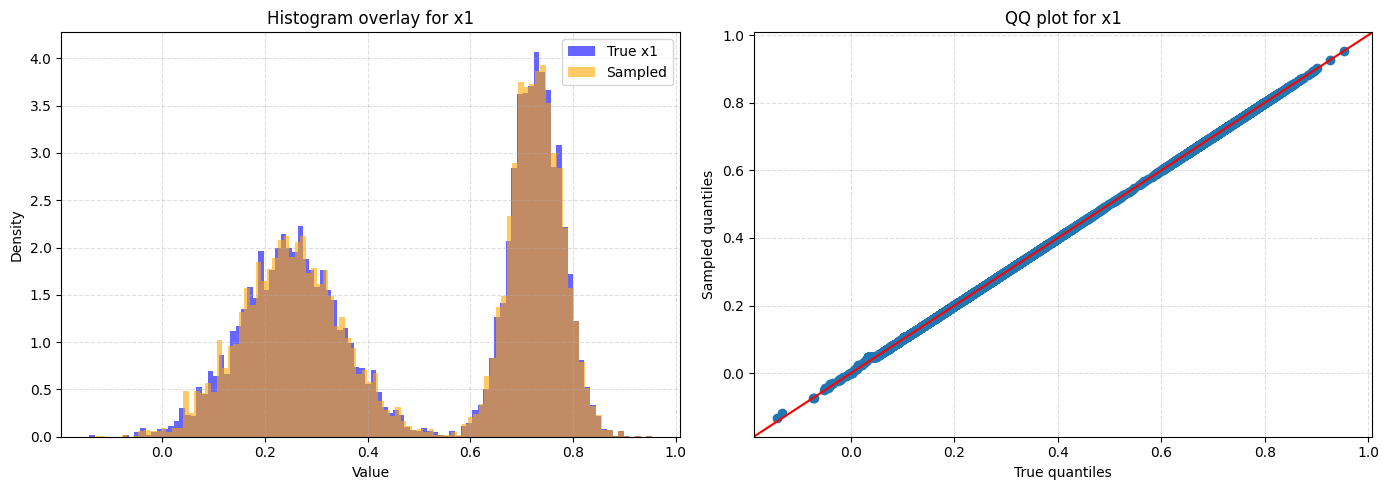

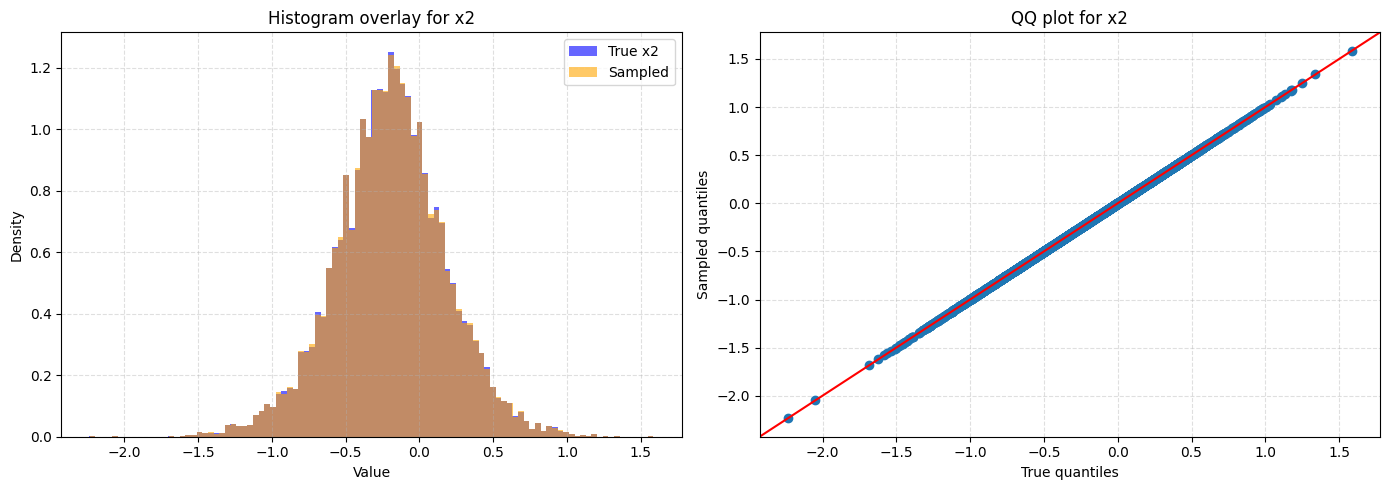

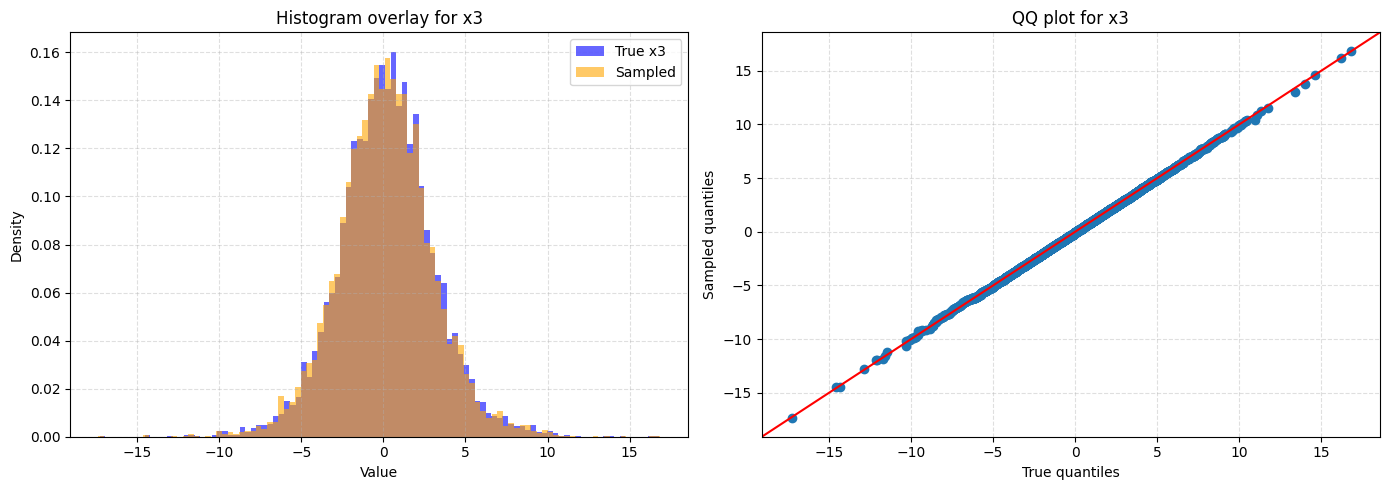

In [22]:
show_samples_vs_true(train_df,node_list,EXPERIMENT_DIR)